# Comparison between kernel-based training and variational circuit using Covalent and Pennylane


In this tutorial, we solve a classification problem using kernel-based training variational training and compare the number of quantum circuits that are evaluated in each case. This is an important parameter in the NISQ era as each circuit evaluation on a real quantum hardware is expensive and time consuming. It is observed that kernel-based training requie only a fraction of the number of circuit evaluations required by variational based training. We show how Covalent framework can help in these kind of situations where multiple evaluations of quantum circuits are needed.

This demo is based on the Pennylane tutorial [**Kernel-based training of quantum models with scikit-learn**](https://pennylane.ai/qml/demos/tutorial_kernel_based_training.html).

We start by importing all the necessary libraries used in the tutorial.



In [1]:
import numpy as np
import torch
from torch.nn.functional import relu

from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pennylane as qml
from pennylane.templates import AngleEmbedding, StronglyEntanglingLayers
from pennylane.operation import Tensor

import matplotlib.pyplot as plt

import covalent as ct


#from covalent.executor import DaskExecutor
#from dask.distributed import LocalCluster

#from dask.distributed import LocalCluster
#cluster=LocalCluster()
#dask=ct.executor.DaskExecutor(scheduler_address=cluster.scheduler_address) 

np.random.seed(42)

# Load, preprocess and split data

We will be using the Iris dataset for the classification problem in this tutorial. We do some necessary preprocessing on the data and split them into training and test dataset.

### Iris dataset

Iris dataset is a very well known dataset used for pattern recognition and classification. It consists of samples belonging to 3 classes namely: Iris Setosa, Iris Versicolour and Iris Virginica. Each sample has four features related to the length and width of sepal and petal. In this tutorial we will be classifying first two classes that correspond to first 100 samples.

In [2]:
X, y = load_iris(return_X_y=True)

# pick inputs and labels from the first two classes only,
# corresponding to the first 100 samples
X = X[:100]
y = y[:100]

# scaling the inputs is important since the embedding we use is periodic
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# scaling the labels to -1, 1 is important for the SVM and the
# definition of a hinge loss
y_scaled = 2 * (y - 0.5)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled)

# Kernel-based training 

Suppose we use a linear classifier for solving a classification problem, it need not always be the case that the classifier is successful. This can be attributed to the fact that samples are not always linearly separable. A common trick to overcome this is to transform the data points to a *higher dimensional* space and perform a linear classification there. This works because performing a linear classification in a *higher dimensional* space corresponds to a non-linear classification in the original space.

In order to perform calculations in a higher dimensional space we use a special function called the *kernel*. The beauty of these functions is that they are able to perform these computations with out transforming the sample data points to the higher dimensional space. Therefore, kernel-based training can bypass the processing and measurement parts of common variational circuits, and only depends on the data encoding. If the loss function used is the hinge loss, the kernel method corresponds to a standard support vector machine (SVM) in the sense of a maximum-margin classifier. In quantum kernel-based training, we will be using quantum computers for computing the kernel function. In this tutorial, we will be PennyLane’s kernels module for creating simple implementations of Quantum Embedding Kernels.


## Constructing the workflow for kernel-based training

The workflow for training based on kernel is broken down into subtasks (functions with the Covalent electron decorator) as follows.

1. `kernel` - The quantum kernel evaluator which calculates the kernel function value between two values. It performs angle embedding for encoding the data features.
2. `kernel_matrix` - Compute the matrix whose entries are the kernel evaluated on pairwise data from sets A and B.
3. `fit_SVC` - It fits a Support Vector Classifer for the supplied kernel matrix.
4. `predict_SVC` - It predicts the classes using the trained SVC.
5. `get_accuracy_score` - Returns the accuracy score for the predicted classes.


In [3]:
n_qubits = len(X_train[0]) #Number of qubits needed for data encoding

dev_kernel = qml.device("default.qubit", wires=n_qubits) #Simulator used for performing kernel-based training.

projector = np.zeros((2**n_qubits, 2**n_qubits))
projector[0, 0] = 1

@ct.electron()
@qml.qnode(dev_kernel)
def kernel(x1, x2):
    AngleEmbedding(x1, wires=range(n_qubits))
    qml.adjoint(AngleEmbedding)(x2, wires=range(n_qubits))
    return qml.expval(qml.Hermitian(projector, wires=range(n_qubits)))

In [4]:
@ct.electron()
def kernel_matrix(A, B):
    return np.array([[kernel(a, b) for b in B] for a in A])

@ct.electron()
def fit_SVC(X_train, y_train,kernel_matrix):
    svm = SVC(kernel=kernel_matrix).fit(X_train, y_train)
    return svm

@ct.electron()
def predict_SVC(svm, X_test):
    predictions = svm.predict(X_test)
    return predictions

@ct.electron()
def get_accuracy_score(predictions, y_test):
    return accuracy_score(predictions, y_test)


We create a waorkflow `kernel_workflow` using Covalent lattice decorator for training a kernel-based classifier and for predicting classes of the test set. We then dispatch the workflow to the dask executor using Covalent `dispatch`. The results are later retrieved by using Covalent `get_result` method.

In [5]:
@ct.lattice
def kernel_workflow(X_train, y_train, X_test, y_test, kernel_matrix):
    svm = fit_SVC(X_train, y_train, kernel_matrix)
    predictions = predict_SVC(svm,X_test)
    acc = get_accuracy_score(predictions, y_test)
    return acc

In [6]:
dispatch_id = ct.dispatch(kernel_workflow)(X_train, y_train, X_test, y_test, kernel_matrix)

In [7]:
kernel_result = ct.get_result(dispatch_id=dispatch_id, wait=True)
kernel_result.result

1.0

# Variational training

Variational circuits consists of quantum circuits that have trainable parameters in them. These parameters are trained with a classical optimization algorithm which looks for better set of parameters at each step of training. The expressivity of the variational algorithm depends on the depth of the ansatz used in the variational circuit.

We will be using gradient-based optimizers and we will use parameter-shift differentiation method for quantum nodes as it works on real quantum hardwares as well. Taking this approach will help us calculate the number of circuit executions needed more accurately.

## Constructing the workflow for variational training

The workflow for training based on variational circuit is broken down into subtasks (functions with the Covalent electron decorator) as follows.

1. `quantum_model` - Evaluates the quantum variational circuit.
2. `quantum_model_plus_bias` - Adds bias to the output of the circuit.
3. `hinge_loss` - Calculates the hinge loss between the predictions and target value.
4. `get_params` - Returns random initial parameters as torch objects.
5. `get_optimizer` - Returns the the optimizer needed for training.
6. `get_batch_data` - Returns the samples used for training in a particular batch.
7. `step_optimizer` - Performs one step of optimization during training.
8. `run_iteration` - Runs one complete iteration of training.
9. `get_random` - Returns random indexes needed to choose batch.
10. `get_torch` - Converts an array into a torch object.
11. `get_pred` - Predict the class based on the output of the model.

In [8]:
dev_var = qml.device("default.qubit", wires=n_qubits)

@ct.electron()
@qml.qnode(dev_var, interface="torch", diff_method="parameter-shift")
def quantum_model(x, params):

    AngleEmbedding(x, wires=range(n_qubits))

    StronglyEntanglingLayers(params, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))

@ct.electron()
def quantum_model_plus_bias(x, params, bias):

    return quantum_model(x, params) + bias

@ct.electron()
def hinge_loss(predictions, targets):

    all_ones = torch.ones_like(targets)
    hinge_loss = all_ones - predictions * targets

    hinge_loss = relu(hinge_loss)
    return hinge_loss

In [9]:
@ct.electron()
def get_params(n_layers):
    params = np.random.random((n_layers, n_qubits, 3))
    params_torch = torch.tensor(params, requires_grad=True)
    bias_torch = torch.tensor(0.0)
    return params_torch, bias_torch

@ct.electron()
def get_optimizer(params_torch, bias_torch):
    return torch.optim.Adam([params_torch, bias_torch], lr=0.1)

@ct.electron()
def get_batch_data(batch_ids):
    X_batch = X_train[batch_ids]
    y_batch = y_train[batch_ids]

    X_batch_torch = torch.tensor(X_batch, requires_grad=False)
    y_batch_torch = torch.tensor(y_batch, requires_grad=False)
    
    return X_batch_torch, y_batch_torch


@ct.electron()
def step_optimizer(opt, params_torch, bias_torch,  X_batch_torch, y_batch_torch):
    def closure():
        opt.zero_grad()
        preds = torch.stack(
            [quantum_model_plus_bias(x, params_torch, bias_torch) for x in X_batch_torch]
        )
        loss = torch.mean(hinge_loss(preds, y_batch_torch))

        loss.backward()
        return loss

    opt.step(closure)
    current_loss = closure().detach().numpy().item()
    return opt, current_loss

@ct.electron()
def get_random(n, batch_size):
    return np.random.choice(n, batch_size)

@ct.electron()
def get_torch(x):
    return torch.tensor(x)

@ct.electron()
def get_pred(pred_torch):
    pred = pred_torch.detach().numpy().item()
    if pred > 0:
        pred = 1
    else:
        pred = -1        
    return pred


@ct.electron()
def run_iteration(opt,batch_size,params_torch,bias_torch):
    batch_ids = get_random(len(X_train), batch_size)

    X_batch_torch, y_batch_torch = get_batch_data(batch_ids=batch_ids)
    
    opt, current_loss = step_optimizer(opt = opt,params_torch = params_torch, bias_torch = bias_torch,  X_batch_torch = X_batch_torch, y_batch_torch = y_batch_torch)
    
    return opt,current_loss

## Training workflow

We create two sublatices `quantum_model_train` and `quantum_model_predict` using Covalent lattice decorator for creating the workflow for training and predicting using the variational circuit.

The `quantum_model_train` workflow runs each step of optimization inside the sub lattice and hence it can save the intermediate optimization steps. This has an advantage when the code is run on an actual quantum hardware as usually each step would be both time and resource costly and hence we would want to monitor not only at the main optimization level, but also at the iteration level. From the DAGs we can see how the results are saved as each step and if any step fails we can use the saved previous computed results to continue further.


We then create the main workflow for training and predicting with `variational_circuit` Covalent lattice. We then dispatch the workflow using Covalent `dispatch`. The results are retrieved by using Covalent `get_result` method. The output is used to compute the accuracy and to plot the loss function.

## Directed Acyclic Graph (DAG)

In order to verify if the workflow construction is properly defined, we can use the draw method in the predict_workflow or check out the DAG in the Covalent UI. The graph contains information on execution status, task definition, runtime, input parameters, and more. 

The Directed Acyclic Graph (DAG) generated for `variational_circuit` workflow is shown below:

![DAG](assets/covalent-kernel-DAG.png)

In [10]:
@ct.electron()
@ct.lattice()
def quantum_model_train(n_layers, steps, batch_size):
    
    params_torch, bias_torch = get_params(n_layers)

    opt = get_optimizer(params_torch, bias_torch)

    loss_history = []
    
    for i in range(steps):

        opt, current_loss = run_iteration(opt=opt,batch_size=batch_size,params_torch=params_torch,bias_torch=bias_torch)
        
        loss_history.append(current_loss)
        
    return params_torch, bias_torch, loss_history



In [11]:
@ct.electron()
@ct.lattice()
def quantum_model_predict(X_pred, trained_params, trained_bias):

    p = []
    for x in X_pred:

        x_torch = get_torch(x=x)
        pred_torch = quantum_model_plus_bias(x=x_torch, params=trained_params, bias=trained_bias)
        
        pred = get_pred(pred_torch=pred_torch)
        p.append(pred)
    return p

In [12]:
@ct.lattice()
def variation_circuit(n_layers, steps, batch_size):
    trained_params, trained_bias, loss_history = quantum_model_train(n_layers=n_layers, steps=steps, batch_size=batch_size)
    pred_test = quantum_model_predict(X_pred = X_test, trained_params=trained_params, trained_bias=trained_bias)
    return loss_history,trained_params, trained_bias, pred_test

accuracy on test set: 0.36


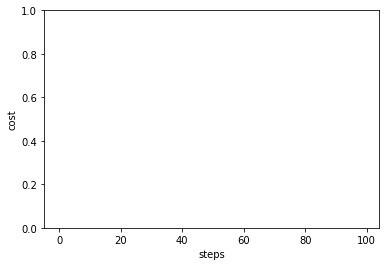

In [13]:
n_layers = 2
batch_size = 20
steps = 100

dispatch_id = ct.dispatch(variation_circuit)(n_layers, steps, batch_size)
result = ct.get_result(dispatch_id=dispatch_id, wait=True)
loss_history,trained_params, trained_bias, pred_test = result.result

#loss_history,trained_params, trained_bias, pred_test = variation_circuit(n_layers, steps, batch_size)

print("accuracy on test set:", accuracy_score(pred_test, y_test))

plt.plot(loss_history)
plt.ylim((0, 1))
plt.xlabel("steps")
plt.ylabel("cost")
plt.show()

# Estimating scalability

We now estimate the number of circuit evaluations needed for kernel and variational based training. The number of circuit evaluations for kernel-based training depends only on the number of samples. This is because it is needed only when constructing the `kernel_matrix` which needs number of samples ^ 2 circuit evaluations. During predicting as the new samples needed to be compared with each of the training sample we need number of training samples * number of predicting samples.


The number of circuit evaluations for variational circuit depends on the number of parameters, samples, step_size during training. This is because, in each optimization step, the partial derivative needs to be evaluated for each parameter and approximately two evaluations are needed per calculation. During prediction, one evaluation is needed per sample.


In the above variational-based training, we used 24 parameters for training with 75 samples. We use this as a reasonable estimate of how many parameters are needed for a given number of training samples. We compare the scalability with two cases where the number of variables:

1. vary linearly with the number of samples: `n_params = M`. In our case this is overfitting.
2. saturates at some point, which we model by setting: `n_params = sqrt(M)`. In our case it is underestimating.

For gradient-based training , it is reasonable to assume that the number of steps: `n_step` varies linearly with the number of samples. 


All these information are plotted with the help of utility functions shown below:

In [14]:
def circuit_evals_kernel(n_data, split):
    """Compute how many circuit evaluations one needs for kernel-based
       training and prediction."""

    M = int(np.ceil(split * n_data))
    Mpred = n_data - M

    n_training = M * M
    n_prediction = M * Mpred

    return n_training + n_prediction

circuit_evals_kernel(n_data=len(X), split=len(X_train) /(len(X_train) + len(X_test)))

7500

In [15]:
def circuit_evals_variational(n_data, n_params, n_steps, shift_terms, split, batch_size):
    """Compute how many circuit evaluations are needed for
       variational training and prediction."""

    M = int(np.ceil(split * n_data))
    Mpred = n_data - M

    n_training = n_params * n_steps * batch_size * shift_terms
    n_prediction = Mpred

    return n_training + n_prediction

circuit_evals_variational(
    n_data=len(X),
    n_params=len(trained_params.flatten()),
    n_steps=steps,
    shift_terms=2,
    split=len(X_train) /(len(X_train) + len(X_test)),
    batch_size=batch_size,
)

96025

In [16]:
def model_evals_nn(n_data, n_params, n_steps, split, batch_size):
    """Compute how many model evaluations are needed for neural
       network training and prediction."""

    M = int(np.ceil(split * n_data))
    Mpred = n_data - M

    n_training = n_steps * batch_size
    n_prediction = Mpred

    return n_training + n_prediction

model_evals_nn(
    n_data=len(X),
    n_params=len(trained_params.flatten()),
    n_steps=steps,
    split=len(X_train) /(len(X_train) + len(X_test)),
    batch_size=batch_size,
)

2025

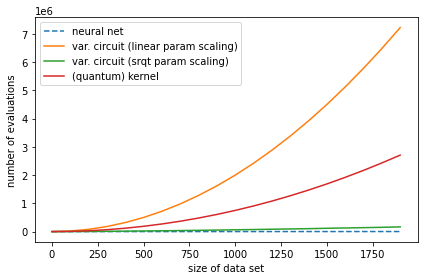

In [17]:
variational_training1 = []
variational_training2 = []
kernelbased_training = []
nn_training = []
x_axis = range(0, 2000, 100)

for M in x_axis:

    var1 = circuit_evals_variational(
        n_data=M, n_params=M, n_steps=M,  shift_terms=2, split=0.75, batch_size=1
    )
    variational_training1.append(var1)

    var2 = circuit_evals_variational(
        n_data=M, n_params=round(np.sqrt(M)), n_steps=M,
        shift_terms=2, split=0.75, batch_size=1
    )
    variational_training2.append(var2)

    kernel = circuit_evals_kernel(n_data=M, split=0.75)
    kernelbased_training.append(kernel)

    nn = model_evals_nn(
        n_data=M, n_params=M, n_steps=M, split=0.75, batch_size=1
    )
    nn_training.append(nn)


plt.plot(x_axis, nn_training, linestyle='--', label="neural net")
plt.plot(x_axis, variational_training1, label="var. circuit (linear param scaling)")
plt.plot(x_axis, variational_training2, label="var. circuit (srqt param scaling)")
plt.plot(x_axis, kernelbased_training, label="(quantum) kernel")
plt.xlabel("size of data set")
plt.ylabel("number of evaluations")
plt.legend()
plt.tight_layout()
plt.show()

# Conclusion

The number of circuit evaluations needed for variational training depends on the number of parameters used. If it is less it performs better than kernel-based methods and vice versa. If variational circuits turn out to be as parameter-hungry as neural networks, kernel-based training will outperform them for common machine learning tasks. However, if variational learning only turns out to require few parameters (or if more efficient training methods are found), variational circuits could in principle match the linear scaling of neural networks trained with backpropagation.

The main conclusion that can be drawn is that kernel-based training can perform better when the number of training parameters for variational circuit is significantly less than the number of training samples.

With the use of Covalent we can create workflows that can save intermediate results during training and also helps us monitor the training process.